In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from statistics import mode
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
# SET50 (unrealize)
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'GLOBAL', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

# remove (low data) : TPIPP WHA SPRC SAWAD PSH MTLS IVL GPSC EA CBG BPP BEAUTY PTTGC

In [3]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('./SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        temp_value = 0
        for row in file_data:
            if row[2] is '':
                continue
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                temp = (float(row[1]) + float(row[4]))/2.0
                if temp_value != 0:
                    unrealize = (temp - temp_value)/ temp_value
                else:
                    unrealize = 0
                unrealize = ["{0:.4f}".format(unrealize)]
                stock_data.append(unrealize)
                temp_value = temp
                
    return stock_data

def mean_square_error(actual, predict):
    length = len(actual)
    sums_error = 0.0
    for i, j in zip(actual, predict):
        sums_error += (i - j)**2
    
    return sums_error / length

def findNewXTest(x_test, predict):
    for (index, element) in enumerate(x_test[0]):
        for i in range(len(element)):
            if i == 0:
                continue
            elif i < 29:
                element[i - 1] = element[i]
            else:
                element[i - 1] = element[i]
                element[i] = "{0:.4f}".format(predict[index])
    return x_test

In [4]:
stock_datas = [ load_stock_data(x, 2007, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

for index, element in enumerate(stock_datas):
    if len(element) < min_count:
        min_count = len(element)

min_count

2043

In [5]:
def create_model(conv_count, fully_count):
    i = 0
    model = Sequential()
    filter_width = 14
    while(i <= conv_count):
        if i == 0:
            model.add(Conv2D(256, (7, 1), input_shape=(len(stock_datas), 30, 1), padding='same'))
        elif i <= 2:
            model.add(Conv2D(128, (3, 1)))
        else:
            model.add(Conv2D(128, (1, 1)))
            
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 1), data_format= "channels_last"))
        i += 1
        
    i = 0
    model.add(Flatten())
    
    while(i <= fully_count):
        if i == fully_count:
            model.add(Dropout(0.2))
            model.add(Dense(len(stock_datas)))
        else:
            model.add(Dense(256))  
            model.add(Activation('relu'))
        i += 1
    
    return model

In [6]:
size = 15
models = [create_model(int(_/5), _%5) for _ in range(size)]
# (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) ... (2, 5)
# first for conv, second for fully connected

In [7]:
lr = 0.95
decay = 1e-6

In [8]:
optimizer = SGD(lr=lr, decay=decay)
for model in models:
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [9]:
rounds = min_count - 30
train_index = int(rounds * 0.85)
validate_index = train_index + int(rounds * 0.05)

In [10]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_validate = x[train_index: validate_index].astype('float32')
x_test = x[validate_index: validate_index + 1].astype('float32')

print(x_train.shape, x_validate.shape, x_test.shape)

(1711, 37, 30, 1) (100, 37, 30, 1) (1, 37, 30, 1)


In [11]:
target = []
index = 0
while index < rounds:
    temp = [stock_datas[i][index + 30][0] for i in range(len(stock_datas))]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_validate = y[train_index: validate_index].astype('float32')
y_test = y[validate_index: rounds].astype('float32')

print(y_train.shape, y_validate.shape, y_test.shape)

(1711, 37) (100, 37) (202, 37)


In [12]:
epochs = 100

for (index, model) in enumerate(models):
    print(index)
    model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, shuffle = True, batch_size = 100, verbose= 1)
    

0
Train on 1711 samples, validate on 100 samples
Epoch 1/100
1711/1711 [==============================] - 15s 9ms/step - loss: 7.7958e-04 - mean_squared_error: 7.7958e-04 - val_loss: 1.4560e-04 - val_mean_squared_error: 1.4560e-04
Epoch 2/100
1711/1711 [==============================] - 3s 2ms/step - loss: 7.7478e-04 - mean_squared_error: 7.7478e-04 - val_loss: 1.4629e-04 - val_mean_squared_error: 1.4629e-04
Epoch 3/100
1711/1711 [==============================] - 3s 2ms/step - loss: 7.7224e-04 - mean_squared_error: 7.7224e-04 - val_loss: 1.4780e-04 - val_mean_squared_error: 1.4780e-04
Epoch 4/100
1711/1711 [==============================] - 3s 2ms/step - loss: 7.6979e-04 - mean_squared_error: 7.6979e-04 - val_loss: 1.4590e-04 - val_mean_squared_error: 1.4590e-04
Epoch 5/100
1711/1711 [==============================] - 3s 2ms/step - loss: 7.6563e-04 - mean_squared_error: 7.6563e-04 - val_loss: 1.4552e-04 - val_mean_squared_error: 1.4552e-04
Epoch 6/100
1711/1711 [======================

Epoch 46/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.9736e-04 - mean_squared_error: 6.9736e-04 - val_loss: 1.4508e-04 - val_mean_squared_error: 1.4508e-04
Epoch 47/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.9724e-04 - mean_squared_error: 6.9724e-04 - val_loss: 1.4490e-04 - val_mean_squared_error: 1.4490e-04
Epoch 48/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.9546e-04 - mean_squared_error: 6.9546e-04 - val_loss: 1.4479e-04 - val_mean_squared_error: 1.4479e-04
Epoch 49/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.9488e-04 - mean_squared_error: 6.9488e-04 - val_loss: 1.4556e-04 - val_mean_squared_error: 1.4556e-04
Epoch 50/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.9394e-04 - mean_squared_error: 6.9394e-04 - val_loss: 1.4534e-04 - val_mean_squared_error: 1.4534e-04
Epoch 51/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.9393e-04 -

1711/1711 [==============================] - 3s 2ms/step - loss: 6.6096e-04 - mean_squared_error: 6.6096e-04 - val_loss: 1.4517e-04 - val_mean_squared_error: 1.4517e-04
Epoch 92/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.6048e-04 - mean_squared_error: 6.6048e-04 - val_loss: 1.4394e-04 - val_mean_squared_error: 1.4394e-04
Epoch 93/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.6168e-04 - mean_squared_error: 6.6168e-04 - val_loss: 1.4522e-04 - val_mean_squared_error: 1.4522e-04
Epoch 94/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.5918e-04 - mean_squared_error: 6.5918e-04 - val_loss: 1.4508e-04 - val_mean_squared_error: 1.4508e-04
Epoch 95/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.5946e-04 - mean_squared_error: 6.5946e-04 - val_loss: 1.4614e-04 - val_mean_squared_error: 1.4614e-04
Epoch 96/100
1711/1711 [==============================] - 3s 2ms/step - loss: 6.5911e-04 - mean_squared

Epoch 36/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2380e-04 - mean_squared_error: 7.2380e-04 - val_loss: 1.4537e-04 - val_mean_squared_error: 1.4537e-04
Epoch 37/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2558e-04 - mean_squared_error: 7.2558e-04 - val_loss: 1.4614e-04 - val_mean_squared_error: 1.4614e-04
Epoch 38/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2209e-04 - mean_squared_error: 7.2209e-04 - val_loss: 1.4687e-04 - val_mean_squared_error: 1.4687e-04
Epoch 39/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2104e-04 - mean_squared_error: 7.2104e-04 - val_loss: 1.4693e-04 - val_mean_squared_error: 1.4693e-04
Epoch 40/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2341e-04 - mean_squared_error: 7.2341e-04 - val_loss: 1.4636e-04 - val_mean_squared_error: 1.4636e-04
Epoch 41/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2108e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 6.8418e-04 - mean_squared_error: 6.8418e-04 - val_loss: 1.4721e-04 - val_mean_squared_error: 1.4721e-04
Epoch 82/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.8665e-04 - mean_squared_error: 6.8665e-04 - val_loss: 1.4730e-04 - val_mean_squared_error: 1.4730e-04
Epoch 83/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.8135e-04 - mean_squared_error: 6.8135e-04 - val_loss: 1.4644e-04 - val_mean_squared_error: 1.4644e-04
Epoch 84/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.8314e-04 - mean_squared_error: 6.8314e-04 - val_loss: 1.4830e-04 - val_mean_squared_error: 1.4830e-04
Epoch 85/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.7885e-04 - mean_squared_error: 6.7885e-04 - val_loss: 1.4568e-04 - val_mean_squared_error: 1.4568e-04
Epoch 86/100
1711/1711 [==============================] - 4s 2ms/step - loss: 6.8309e-04 - mean_squared

Epoch 26/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4818e-04 - mean_squared_error: 7.4818e-04 - val_loss: 1.4770e-04 - val_mean_squared_error: 1.4770e-04
Epoch 27/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4511e-04 - mean_squared_error: 7.4511e-04 - val_loss: 1.4913e-04 - val_mean_squared_error: 1.4913e-04
Epoch 28/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4548e-04 - mean_squared_error: 7.4548e-04 - val_loss: 1.4607e-04 - val_mean_squared_error: 1.4607e-04
Epoch 29/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4420e-04 - mean_squared_error: 7.4420e-04 - val_loss: 1.4788e-04 - val_mean_squared_error: 1.4788e-04
Epoch 30/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4532e-04 - mean_squared_error: 7.4532e-04 - val_loss: 1.4600e-04 - val_mean_squared_error: 1.4600e-04
Epoch 31/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4306e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.1627e-04 - mean_squared_error: 7.1627e-04 - val_loss: 1.4535e-04 - val_mean_squared_error: 1.4535e-04
Epoch 72/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.1527e-04 - mean_squared_error: 7.1527e-04 - val_loss: 1.4734e-04 - val_mean_squared_error: 1.4734e-04
Epoch 73/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.1585e-04 - mean_squared_error: 7.1585e-04 - val_loss: 1.4585e-04 - val_mean_squared_error: 1.4585e-04
Epoch 74/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.1116e-04 - mean_squared_error: 7.1116e-04 - val_loss: 1.4756e-04 - val_mean_squared_error: 1.4756e-04
Epoch 75/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.1506e-04 - mean_squared_error: 7.1506e-04 - val_loss: 1.4627e-04 - val_mean_squared_error: 1.4627e-04
Epoch 76/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.1173e-04 - mean_squared

Epoch 16/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6255e-04 - mean_squared_error: 7.6255e-04 - val_loss: 1.4619e-04 - val_mean_squared_error: 1.4619e-04
Epoch 17/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6203e-04 - mean_squared_error: 7.6203e-04 - val_loss: 1.5710e-04 - val_mean_squared_error: 1.5710e-04
Epoch 18/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6343e-04 - mean_squared_error: 7.6343e-04 - val_loss: 1.4573e-04 - val_mean_squared_error: 1.4573e-04
Epoch 19/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6172e-04 - mean_squared_error: 7.6172e-04 - val_loss: 1.4818e-04 - val_mean_squared_error: 1.4818e-04
Epoch 20/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6124e-04 - mean_squared_error: 7.6124e-04 - val_loss: 1.4660e-04 - val_mean_squared_error: 1.4660e-04
Epoch 21/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6000e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.4223e-04 - mean_squared_error: 7.4223e-04 - val_loss: 1.4730e-04 - val_mean_squared_error: 1.4730e-04
Epoch 62/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4068e-04 - mean_squared_error: 7.4068e-04 - val_loss: 1.4566e-04 - val_mean_squared_error: 1.4566e-04
Epoch 63/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.3974e-04 - mean_squared_error: 7.3974e-04 - val_loss: 1.4693e-04 - val_mean_squared_error: 1.4693e-04
Epoch 64/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4064e-04 - mean_squared_error: 7.4064e-04 - val_loss: 1.4695e-04 - val_mean_squared_error: 1.4695e-04
Epoch 65/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.3851e-04 - mean_squared_error: 7.3851e-04 - val_loss: 1.4618e-04 - val_mean_squared_error: 1.4618e-04
Epoch 66/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.3960e-04 - mean_squared

Epoch 6/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6608e-04 - mean_squared_error: 7.6608e-04 - val_loss: 1.4641e-04 - val_mean_squared_error: 1.4641e-04
Epoch 7/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6557e-04 - mean_squared_error: 7.6557e-04 - val_loss: 1.4617e-04 - val_mean_squared_error: 1.4617e-04
Epoch 8/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6538e-04 - mean_squared_error: 7.6538e-04 - val_loss: 1.4672e-04 - val_mean_squared_error: 1.4672e-04
Epoch 9/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6414e-04 - mean_squared_error: 7.6414e-04 - val_loss: 1.4593e-04 - val_mean_squared_error: 1.4593e-04
Epoch 10/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6491e-04 - mean_squared_error: 7.6491e-04 - val_loss: 1.4555e-04 - val_mean_squared_error: 1.4555e-04
Epoch 11/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6355e-04 - mea

1711/1711 [==============================] - 4s 2ms/step - loss: 7.4361e-04 - mean_squared_error: 7.4361e-04 - val_loss: 1.4821e-04 - val_mean_squared_error: 1.4821e-04
Epoch 52/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4197e-04 - mean_squared_error: 7.4197e-04 - val_loss: 1.4752e-04 - val_mean_squared_error: 1.4752e-04
Epoch 53/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4180e-04 - mean_squared_error: 7.4180e-04 - val_loss: 1.4724e-04 - val_mean_squared_error: 1.4724e-04
Epoch 54/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4181e-04 - mean_squared_error: 7.4181e-04 - val_loss: 1.4474e-04 - val_mean_squared_error: 1.4474e-04
Epoch 55/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4113e-04 - mean_squared_error: 7.4113e-04 - val_loss: 1.4815e-04 - val_mean_squared_error: 1.4815e-04
Epoch 56/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4074e-04 - mean_squared

1711/1711 [==============================] - 4s 2ms/step - loss: 7.2270e-04 - mean_squared_error: 7.2270e-04 - val_loss: 2.5073e-04 - val_mean_squared_error: 2.5073e-04
Epoch 97/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2827e-04 - mean_squared_error: 7.2827e-04 - val_loss: 1.4533e-04 - val_mean_squared_error: 1.4533e-04
Epoch 98/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2192e-04 - mean_squared_error: 7.2192e-04 - val_loss: 1.4564e-04 - val_mean_squared_error: 1.4564e-04
Epoch 99/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.1842e-04 - mean_squared_error: 7.1842e-04 - val_loss: 1.4569e-04 - val_mean_squared_error: 1.4569e-04
Epoch 100/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.1927e-04 - mean_squared_error: 7.1927e-04 - val_loss: 1.4618e-04 - val_mean_squared_error: 1.4618e-04
5
Train on 1711 samples, validate on 100 samples
Epoch 1/100
1711/1711 [==============================

Epoch 41/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4994e-04 - mean_squared_error: 7.4994e-04 - val_loss: 1.4674e-04 - val_mean_squared_error: 1.4674e-04
Epoch 42/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5009e-04 - mean_squared_error: 7.5009e-04 - val_loss: 1.4676e-04 - val_mean_squared_error: 1.4676e-04
Epoch 43/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4809e-04 - mean_squared_error: 7.4809e-04 - val_loss: 1.4686e-04 - val_mean_squared_error: 1.4686e-04
Epoch 44/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4790e-04 - mean_squared_error: 7.4790e-04 - val_loss: 1.4533e-04 - val_mean_squared_error: 1.4533e-04
Epoch 45/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4886e-04 - mean_squared_error: 7.4886e-04 - val_loss: 1.4604e-04 - val_mean_squared_error: 1.4604e-04
Epoch 46/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4764e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.2462e-04 - mean_squared_error: 7.2462e-04 - val_loss: 1.4556e-04 - val_mean_squared_error: 1.4556e-04
Epoch 87/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2242e-04 - mean_squared_error: 7.2242e-04 - val_loss: 1.4587e-04 - val_mean_squared_error: 1.4587e-04
Epoch 88/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2393e-04 - mean_squared_error: 7.2393e-04 - val_loss: 1.4622e-04 - val_mean_squared_error: 1.4622e-04
Epoch 89/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2190e-04 - mean_squared_error: 7.2190e-04 - val_loss: 1.4737e-04 - val_mean_squared_error: 1.4737e-04
Epoch 90/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2268e-04 - mean_squared_error: 7.2268e-04 - val_loss: 1.4603e-04 - val_mean_squared_error: 1.4603e-04
Epoch 91/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.2307e-04 - mean_squared

Epoch 31/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5725e-04 - mean_squared_error: 7.5725e-04 - val_loss: 1.4784e-04 - val_mean_squared_error: 1.4784e-04
Epoch 32/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5818e-04 - mean_squared_error: 7.5818e-04 - val_loss: 1.4568e-04 - val_mean_squared_error: 1.4568e-04
Epoch 33/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5681e-04 - mean_squared_error: 7.5681e-04 - val_loss: 1.4585e-04 - val_mean_squared_error: 1.4585e-04
Epoch 34/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5701e-04 - mean_squared_error: 7.5701e-04 - val_loss: 1.4748e-04 - val_mean_squared_error: 1.4748e-04
Epoch 35/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5563e-04 - mean_squared_error: 7.5563e-04 - val_loss: 1.4610e-04 - val_mean_squared_error: 1.4610e-04
Epoch 36/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5495e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.3967e-04 - mean_squared_error: 7.3967e-04 - val_loss: 1.5837e-04 - val_mean_squared_error: 1.5837e-04
Epoch 77/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4172e-04 - mean_squared_error: 7.4172e-04 - val_loss: 1.4641e-04 - val_mean_squared_error: 1.4641e-04
Epoch 78/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4108e-04 - mean_squared_error: 7.4108e-04 - val_loss: 1.4835e-04 - val_mean_squared_error: 1.4835e-04
Epoch 79/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.3888e-04 - mean_squared_error: 7.3888e-04 - val_loss: 1.4688e-04 - val_mean_squared_error: 1.4688e-04
Epoch 80/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.3911e-04 - mean_squared_error: 7.3911e-04 - val_loss: 1.4517e-04 - val_mean_squared_error: 1.4517e-04
Epoch 81/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.3919e-04 - mean_squared

Epoch 21/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6245e-04 - mean_squared_error: 7.6245e-04 - val_loss: 1.4619e-04 - val_mean_squared_error: 1.4619e-04
Epoch 22/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6218e-04 - mean_squared_error: 7.6218e-04 - val_loss: 1.4712e-04 - val_mean_squared_error: 1.4712e-04
Epoch 23/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6160e-04 - mean_squared_error: 7.6160e-04 - val_loss: 1.4653e-04 - val_mean_squared_error: 1.4653e-04
Epoch 24/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6282e-04 - mean_squared_error: 7.6282e-04 - val_loss: 1.4722e-04 - val_mean_squared_error: 1.4722e-04
Epoch 25/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6164e-04 - mean_squared_error: 7.6164e-04 - val_loss: 1.4710e-04 - val_mean_squared_error: 1.4710e-04
Epoch 26/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6181e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5213e-04 - mean_squared_error: 7.5213e-04 - val_loss: 1.4807e-04 - val_mean_squared_error: 1.4807e-04
Epoch 67/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5174e-04 - mean_squared_error: 7.5174e-04 - val_loss: 1.4709e-04 - val_mean_squared_error: 1.4709e-04
Epoch 68/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5073e-04 - mean_squared_error: 7.5073e-04 - val_loss: 1.4621e-04 - val_mean_squared_error: 1.4621e-04
Epoch 69/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5069e-04 - mean_squared_error: 7.5069e-04 - val_loss: 1.4631e-04 - val_mean_squared_error: 1.4631e-04
Epoch 70/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.4904e-04 - mean_squared_error: 7.4904e-04 - val_loss: 1.4690e-04 - val_mean_squared_error: 1.4690e-04
Epoch 71/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5115e-04 - mean_squared

Epoch 11/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6569e-04 - mean_squared_error: 7.6569e-04 - val_loss: 1.4626e-04 - val_mean_squared_error: 1.4626e-04
Epoch 12/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6568e-04 - mean_squared_error: 7.6568e-04 - val_loss: 1.4615e-04 - val_mean_squared_error: 1.4615e-04
Epoch 13/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6500e-04 - mean_squared_error: 7.6500e-04 - val_loss: 1.4617e-04 - val_mean_squared_error: 1.4617e-04
Epoch 14/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6481e-04 - mean_squared_error: 7.6481e-04 - val_loss: 1.4527e-04 - val_mean_squared_error: 1.4527e-04
Epoch 15/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6506e-04 - mean_squared_error: 7.6506e-04 - val_loss: 1.4627e-04 - val_mean_squared_error: 1.4627e-04
Epoch 16/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6455e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5690e-04 - mean_squared_error: 7.5690e-04 - val_loss: 1.4625e-04 - val_mean_squared_error: 1.4625e-04
Epoch 57/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5639e-04 - mean_squared_error: 7.5639e-04 - val_loss: 1.4569e-04 - val_mean_squared_error: 1.4569e-04
Epoch 58/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5577e-04 - mean_squared_error: 7.5577e-04 - val_loss: 1.4773e-04 - val_mean_squared_error: 1.4773e-04
Epoch 59/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5711e-04 - mean_squared_error: 7.5711e-04 - val_loss: 1.4676e-04 - val_mean_squared_error: 1.4676e-04
Epoch 60/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5627e-04 - mean_squared_error: 7.5627e-04 - val_loss: 1.4534e-04 - val_mean_squared_error: 1.4534e-04
Epoch 61/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5544e-04 - mean_squared

1711/1711 [==============================] - 4s 3ms/step - loss: 7.7077e-04 - mean_squared_error: 7.7077e-04 - val_loss: 1.4633e-04 - val_mean_squared_error: 1.4633e-04
Epoch 2/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6943e-04 - mean_squared_error: 7.6943e-04 - val_loss: 1.4600e-04 - val_mean_squared_error: 1.4600e-04
Epoch 3/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6894e-04 - mean_squared_error: 7.6894e-04 - val_loss: 1.4566e-04 - val_mean_squared_error: 1.4566e-04
Epoch 4/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6910e-04 - mean_squared_error: 7.6910e-04 - val_loss: 1.4637e-04 - val_mean_squared_error: 1.4637e-04
Epoch 5/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6849e-04 - mean_squared_error: 7.6849e-04 - val_loss: 1.5281e-04 - val_mean_squared_error: 1.5281e-04
Epoch 6/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6856e-04 - mean_squared_erro

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6122e-04 - mean_squared_error: 7.6122e-04 - val_loss: 1.4620e-04 - val_mean_squared_error: 1.4620e-04
Epoch 47/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6089e-04 - mean_squared_error: 7.6089e-04 - val_loss: 1.6117e-04 - val_mean_squared_error: 1.6117e-04
Epoch 48/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6308e-04 - mean_squared_error: 7.6308e-04 - val_loss: 1.4659e-04 - val_mean_squared_error: 1.4659e-04
Epoch 49/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6057e-04 - mean_squared_error: 7.6057e-04 - val_loss: 1.4577e-04 - val_mean_squared_error: 1.4577e-04
Epoch 50/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6081e-04 - mean_squared_error: 7.6081e-04 - val_loss: 1.4539e-04 - val_mean_squared_error: 1.4539e-04
Epoch 51/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6014e-04 - mean_squared

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5467e-04 - mean_squared_error: 7.5467e-04 - val_loss: 1.4611e-04 - val_mean_squared_error: 1.4611e-04
Epoch 92/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5356e-04 - mean_squared_error: 7.5356e-04 - val_loss: 1.4762e-04 - val_mean_squared_error: 1.4762e-04
Epoch 93/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5533e-04 - mean_squared_error: 7.5533e-04 - val_loss: 1.4570e-04 - val_mean_squared_error: 1.4570e-04
Epoch 94/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5336e-04 - mean_squared_error: 7.5336e-04 - val_loss: 1.4769e-04 - val_mean_squared_error: 1.4769e-04
Epoch 95/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5434e-04 - mean_squared_error: 7.5434e-04 - val_loss: 1.4450e-04 - val_mean_squared_error: 1.4450e-04
Epoch 96/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5390e-04 - mean_squared

Epoch 36/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.6499e-04 - mean_squared_error: 7.6499e-04 - val_loss: 1.4631e-04 - val_mean_squared_error: 1.4631e-04
Epoch 37/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.6432e-04 - mean_squared_error: 7.6432e-04 - val_loss: 1.4606e-04 - val_mean_squared_error: 1.4606e-04
Epoch 38/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.6431e-04 - mean_squared_error: 7.6431e-04 - val_loss: 1.4679e-04 - val_mean_squared_error: 1.4679e-04
Epoch 39/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.6427e-04 - mean_squared_error: 7.6427e-04 - val_loss: 1.4572e-04 - val_mean_squared_error: 1.4572e-04
Epoch 40/100
1711/1711 [==============================] - 5s 3ms/step - loss: 7.6306e-04 - mean_squared_error: 7.6306e-04 - val_loss: 1.4656e-04 - val_mean_squared_error: 1.4656e-04
Epoch 41/100
1711/1711 [==============================] - 4s 3ms/step - loss: 7.6389e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5516e-04 - mean_squared_error: 7.5516e-04 - val_loss: 1.4642e-04 - val_mean_squared_error: 1.4642e-04
Epoch 82/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5546e-04 - mean_squared_error: 7.5546e-04 - val_loss: 1.4554e-04 - val_mean_squared_error: 1.4554e-04
Epoch 83/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5597e-04 - mean_squared_error: 7.5597e-04 - val_loss: 1.4551e-04 - val_mean_squared_error: 1.4551e-04
Epoch 84/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5500e-04 - mean_squared_error: 7.5500e-04 - val_loss: 1.4556e-04 - val_mean_squared_error: 1.4556e-04
Epoch 85/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5529e-04 - mean_squared_error: 7.5529e-04 - val_loss: 1.4512e-04 - val_mean_squared_error: 1.4512e-04
Epoch 86/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5353e-04 - mean_squared

Epoch 26/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6643e-04 - mean_squared_error: 7.6643e-04 - val_loss: 1.4781e-04 - val_mean_squared_error: 1.4781e-04
Epoch 27/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6525e-04 - mean_squared_error: 7.6525e-04 - val_loss: 1.4613e-04 - val_mean_squared_error: 1.4613e-04
Epoch 28/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6490e-04 - mean_squared_error: 7.6490e-04 - val_loss: 1.4738e-04 - val_mean_squared_error: 1.4738e-04
Epoch 29/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6560e-04 - mean_squared_error: 7.6560e-04 - val_loss: 1.4576e-04 - val_mean_squared_error: 1.4576e-04
Epoch 30/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6437e-04 - mean_squared_error: 7.6437e-04 - val_loss: 1.4609e-04 - val_mean_squared_error: 1.4609e-04
Epoch 31/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6461e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5980e-04 - mean_squared_error: 7.5980e-04 - val_loss: 1.5230e-04 - val_mean_squared_error: 1.5230e-04
Epoch 72/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6008e-04 - mean_squared_error: 7.6008e-04 - val_loss: 1.4701e-04 - val_mean_squared_error: 1.4701e-04
Epoch 73/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5938e-04 - mean_squared_error: 7.5938e-04 - val_loss: 1.4552e-04 - val_mean_squared_error: 1.4552e-04
Epoch 74/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6000e-04 - mean_squared_error: 7.6000e-04 - val_loss: 1.4668e-04 - val_mean_squared_error: 1.4668e-04
Epoch 75/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5880e-04 - mean_squared_error: 7.5880e-04 - val_loss: 1.4709e-04 - val_mean_squared_error: 1.4709e-04
Epoch 76/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5865e-04 - mean_squared

Epoch 16/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6525e-04 - mean_squared_error: 7.6525e-04 - val_loss: 1.4571e-04 - val_mean_squared_error: 1.4571e-04
Epoch 17/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6584e-04 - mean_squared_error: 7.6584e-04 - val_loss: 1.4613e-04 - val_mean_squared_error: 1.4613e-04
Epoch 18/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6468e-04 - mean_squared_error: 7.6468e-04 - val_loss: 1.4703e-04 - val_mean_squared_error: 1.4703e-04
Epoch 19/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6470e-04 - mean_squared_error: 7.6470e-04 - val_loss: 1.4537e-04 - val_mean_squared_error: 1.4537e-04
Epoch 20/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6451e-04 - mean_squared_error: 7.6451e-04 - val_loss: 1.4657e-04 - val_mean_squared_error: 1.4657e-04
Epoch 21/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6420e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5976e-04 - mean_squared_error: 7.5976e-04 - val_loss: 1.4752e-04 - val_mean_squared_error: 1.4752e-04
Epoch 62/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5987e-04 - mean_squared_error: 7.5987e-04 - val_loss: 1.4558e-04 - val_mean_squared_error: 1.4558e-04
Epoch 63/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5959e-04 - mean_squared_error: 7.5959e-04 - val_loss: 1.4525e-04 - val_mean_squared_error: 1.4525e-04
Epoch 64/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5855e-04 - mean_squared_error: 7.5855e-04 - val_loss: 1.5319e-04 - val_mean_squared_error: 1.5319e-04
Epoch 65/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6073e-04 - mean_squared_error: 7.6073e-04 - val_loss: 1.4649e-04 - val_mean_squared_error: 1.4649e-04
Epoch 66/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5860e-04 - mean_squared

Epoch 6/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6848e-04 - mean_squared_error: 7.6848e-04 - val_loss: 1.4614e-04 - val_mean_squared_error: 1.4614e-04
Epoch 7/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6756e-04 - mean_squared_error: 7.6756e-04 - val_loss: 1.4651e-04 - val_mean_squared_error: 1.4651e-04
Epoch 8/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6739e-04 - mean_squared_error: 7.6739e-04 - val_loss: 1.4554e-04 - val_mean_squared_error: 1.4554e-04
Epoch 9/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6727e-04 - mean_squared_error: 7.6727e-04 - val_loss: 1.4572e-04 - val_mean_squared_error: 1.4572e-04
Epoch 10/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6670e-04 - mean_squared_error: 7.6670e-04 - val_loss: 1.4611e-04 - val_mean_squared_error: 1.4611e-04
Epoch 11/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6651e-04 - mea

1711/1711 [==============================] - 4s 2ms/step - loss: 7.6197e-04 - mean_squared_error: 7.6197e-04 - val_loss: 1.4552e-04 - val_mean_squared_error: 1.4552e-04
Epoch 52/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6218e-04 - mean_squared_error: 7.6218e-04 - val_loss: 1.4653e-04 - val_mean_squared_error: 1.4653e-04
Epoch 53/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6193e-04 - mean_squared_error: 7.6193e-04 - val_loss: 1.4478e-04 - val_mean_squared_error: 1.4478e-04
Epoch 54/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6118e-04 - mean_squared_error: 7.6118e-04 - val_loss: 1.6199e-04 - val_mean_squared_error: 1.6199e-04
Epoch 55/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6465e-04 - mean_squared_error: 7.6465e-04 - val_loss: 1.4826e-04 - val_mean_squared_error: 1.4826e-04
Epoch 56/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6138e-04 - mean_squared

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5718e-04 - mean_squared_error: 7.5718e-04 - val_loss: 1.4563e-04 - val_mean_squared_error: 1.4563e-04
Epoch 97/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5626e-04 - mean_squared_error: 7.5626e-04 - val_loss: 1.4710e-04 - val_mean_squared_error: 1.4710e-04
Epoch 98/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5652e-04 - mean_squared_error: 7.5652e-04 - val_loss: 1.5206e-04 - val_mean_squared_error: 1.5206e-04
Epoch 99/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5782e-04 - mean_squared_error: 7.5782e-04 - val_loss: 1.4788e-04 - val_mean_squared_error: 1.4788e-04
Epoch 100/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5807e-04 - mean_squared_error: 7.5807e-04 - val_loss: 1.4585e-04 - val_mean_squared_error: 1.4585e-04
14
Train on 1711 samples, validate on 100 samples
Epoch 1/100
1711/1711 [=============================

Epoch 41/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6423e-04 - mean_squared_error: 7.6423e-04 - val_loss: 1.4646e-04 - val_mean_squared_error: 1.4646e-04
Epoch 42/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6404e-04 - mean_squared_error: 7.6404e-04 - val_loss: 1.6233e-04 - val_mean_squared_error: 1.6233e-04
Epoch 43/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6646e-04 - mean_squared_error: 7.6646e-04 - val_loss: 1.4686e-04 - val_mean_squared_error: 1.4686e-04
Epoch 44/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6358e-04 - mean_squared_error: 7.6358e-04 - val_loss: 1.4707e-04 - val_mean_squared_error: 1.4707e-04
Epoch 45/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6364e-04 - mean_squared_error: 7.6364e-04 - val_loss: 1.4591e-04 - val_mean_squared_error: 1.4591e-04
Epoch 46/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6373e-04 -

1711/1711 [==============================] - 4s 2ms/step - loss: 7.5992e-04 - mean_squared_error: 7.5992e-04 - val_loss: 1.4639e-04 - val_mean_squared_error: 1.4639e-04
Epoch 87/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6000e-04 - mean_squared_error: 7.6000e-04 - val_loss: 1.4585e-04 - val_mean_squared_error: 1.4585e-04
Epoch 88/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.5968e-04 - mean_squared_error: 7.5968e-04 - val_loss: 1.4535e-04 - val_mean_squared_error: 1.4535e-04
Epoch 89/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6042e-04 - mean_squared_error: 7.6042e-04 - val_loss: 1.5114e-04 - val_mean_squared_error: 1.5114e-04
Epoch 90/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6038e-04 - mean_squared_error: 7.6038e-04 - val_loss: 1.4872e-04 - val_mean_squared_error: 1.4872e-04
Epoch 91/100
1711/1711 [==============================] - 4s 2ms/step - loss: 7.6044e-04 - mean_squared

In [16]:
errors = [[] for i in range(size)]
predicts = [[] for i in range(size)]
for i in range(size):
    test_data = x_test.copy()
    for (index, element) in enumerate(y_test):
        predict = models[i].predict(test_data, verbose = 0)
        predicts[i].append(predict[0])
        errors[i].append(mean_square_error(element, predict[0]))
        test_data = findNewXTest(test_data, predict[0])

In [17]:
predicts = [np.asarray(predict).astype('float32') for predict in predicts]

In [18]:
def plot_graph(array1, array2, array3, array4):
    plt.figure(figsize=(20,10))
    x_axis = [i for i in range(len(array1))]
    plt.plot(x_axis, array1, 'r')
    plt.plot(x_axis, array2, 'b')
    plt.plot(x_axis, array3, 'g')
    plt.plot(x_axis, array4, 'y')

    plt.show()
    
def get_data_from_nparray(nparray, index):
    return_data = [i[index] for i in nparray]
    return return_data

ADVANC


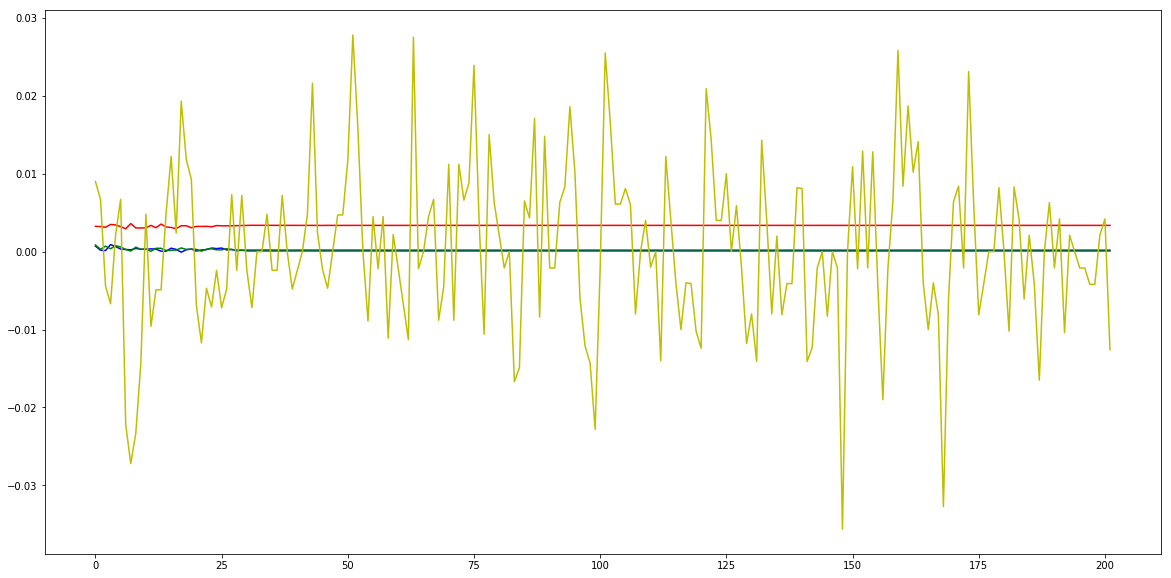

AOT


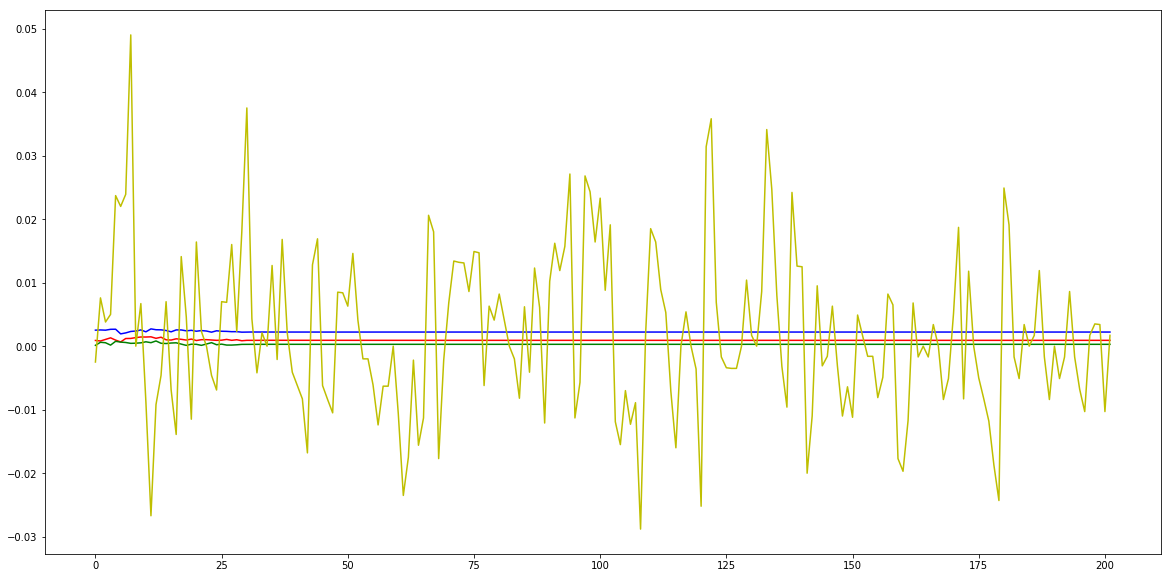

BANPU


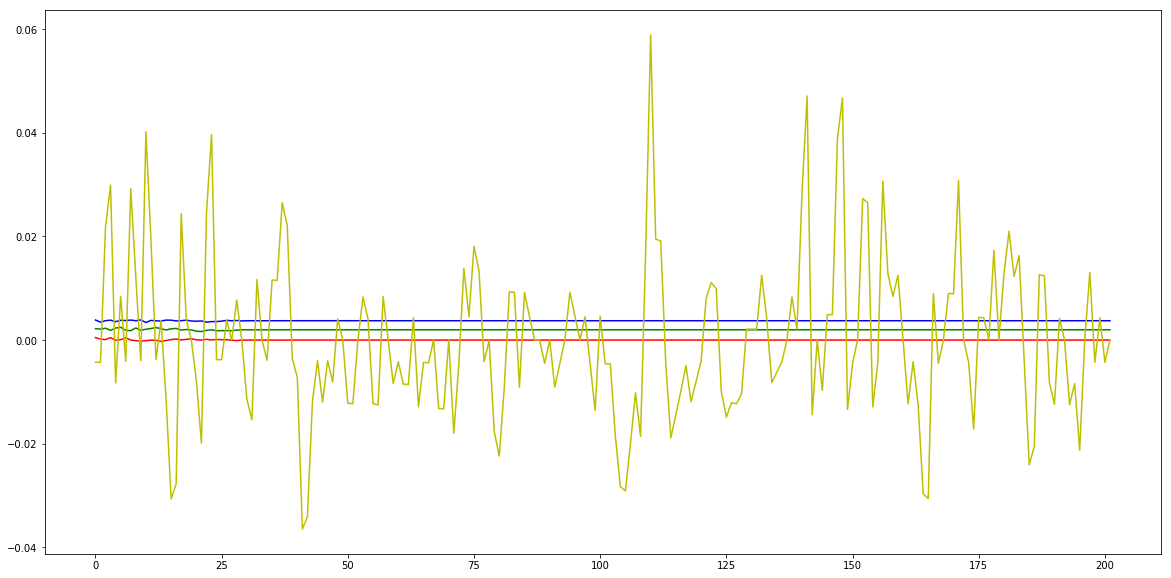

BBL


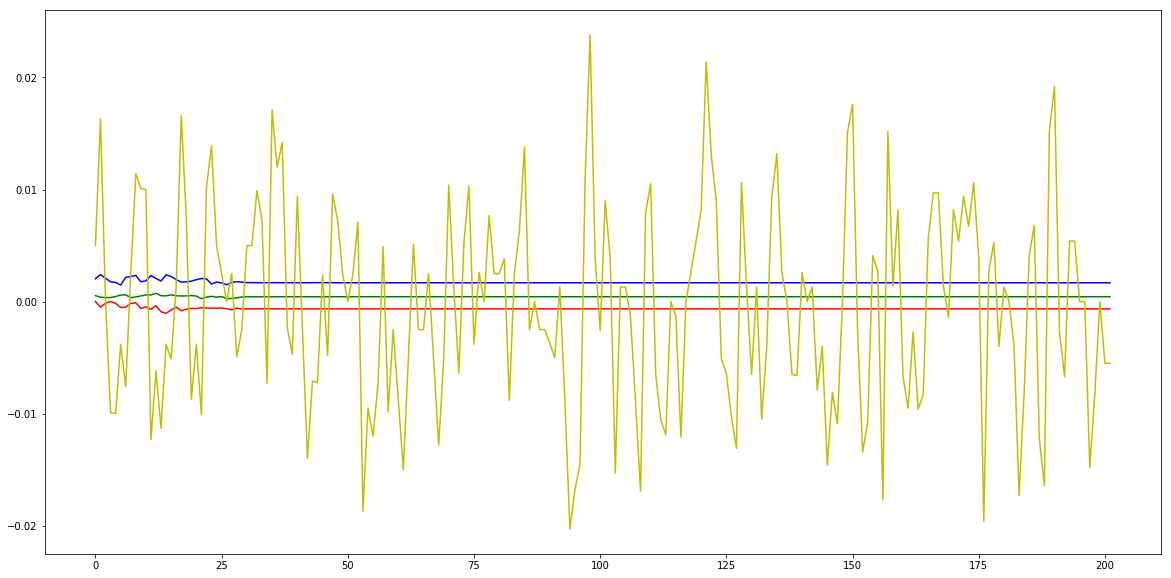

BCP


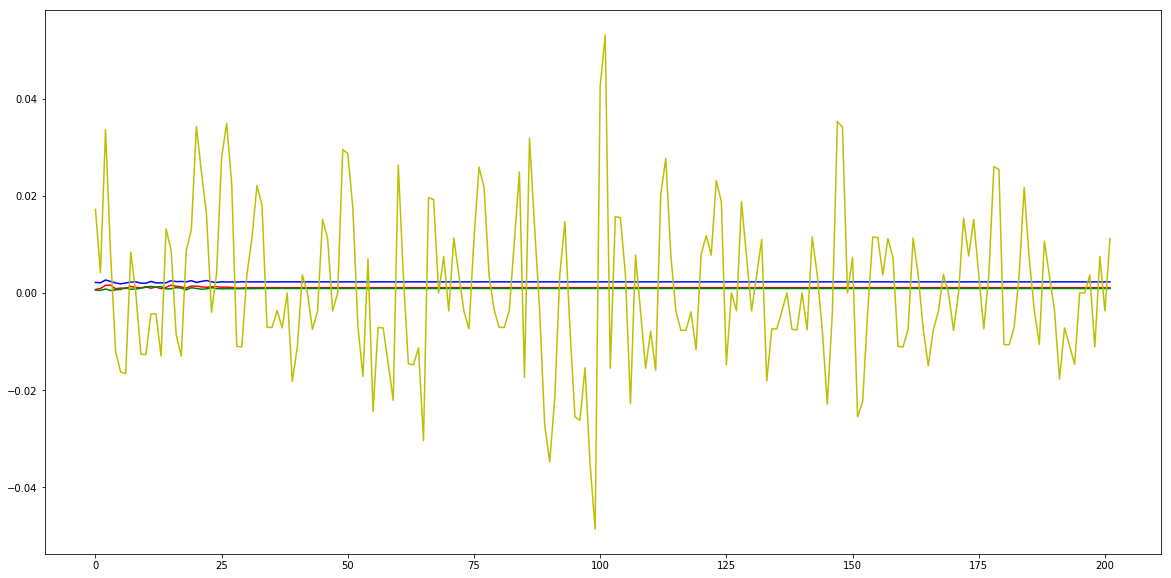

BDMS


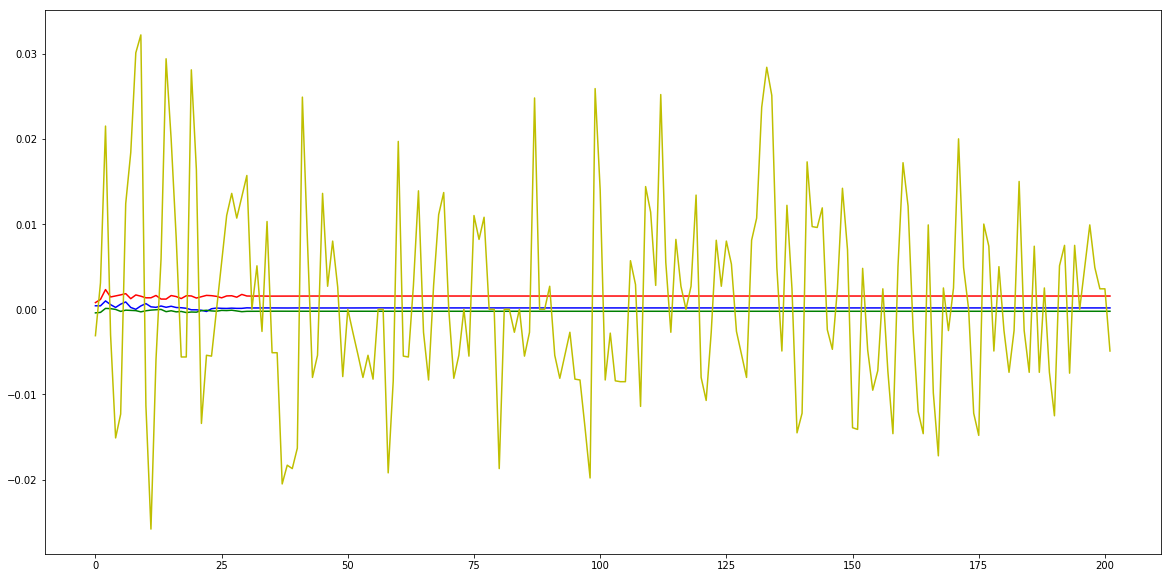

BEM


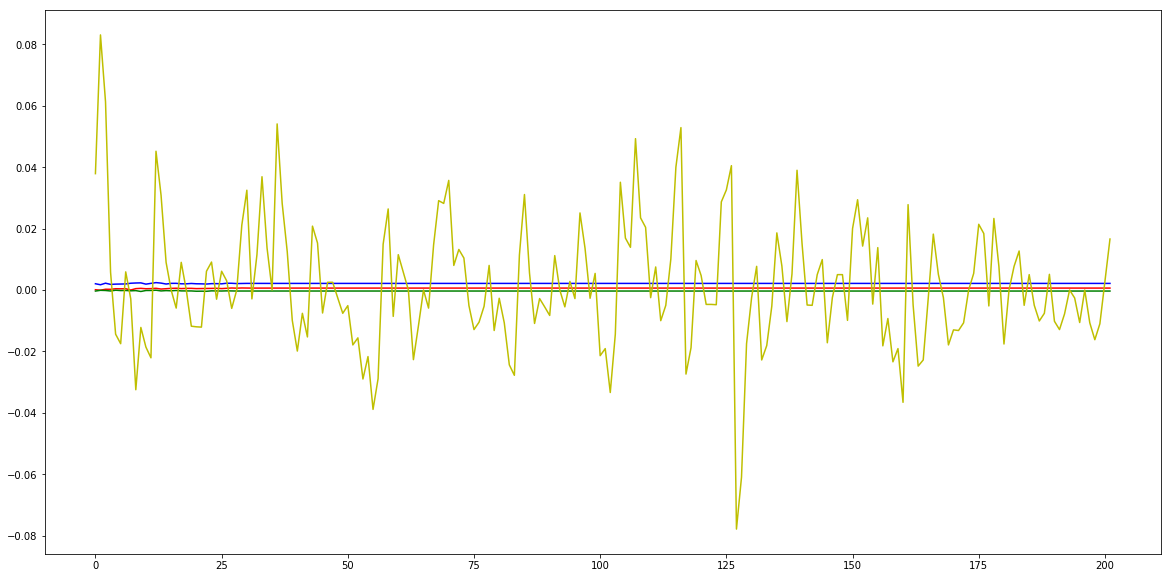

BH


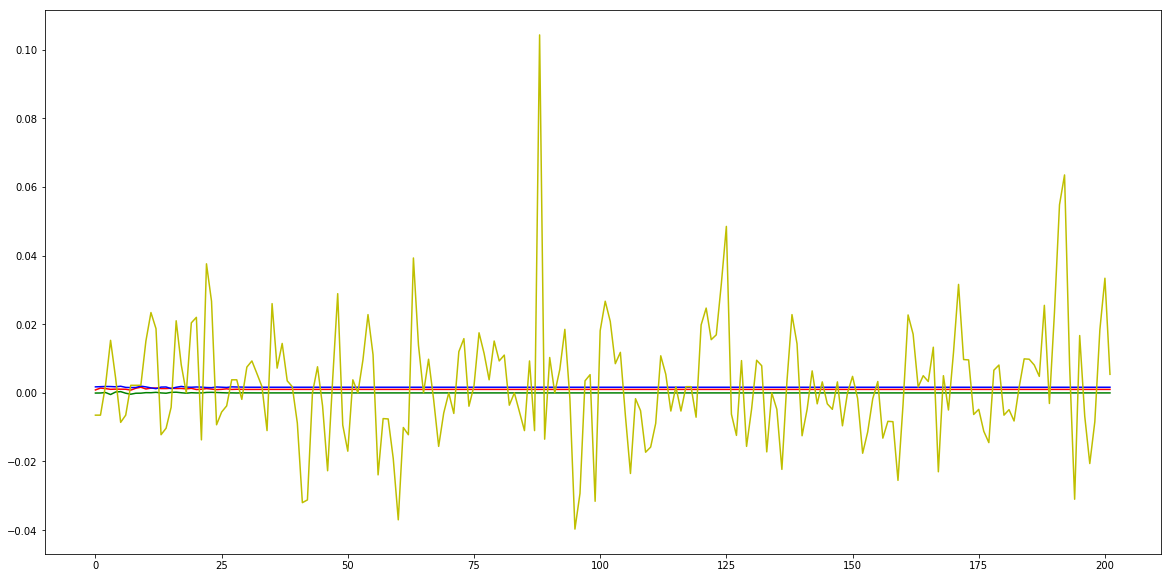

BJC


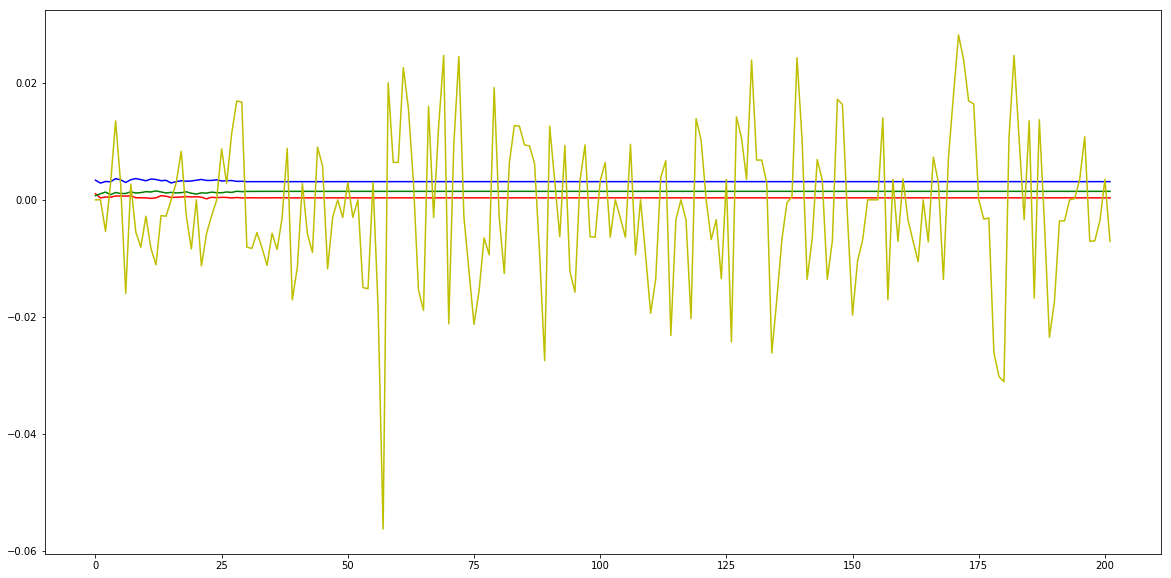

BTS


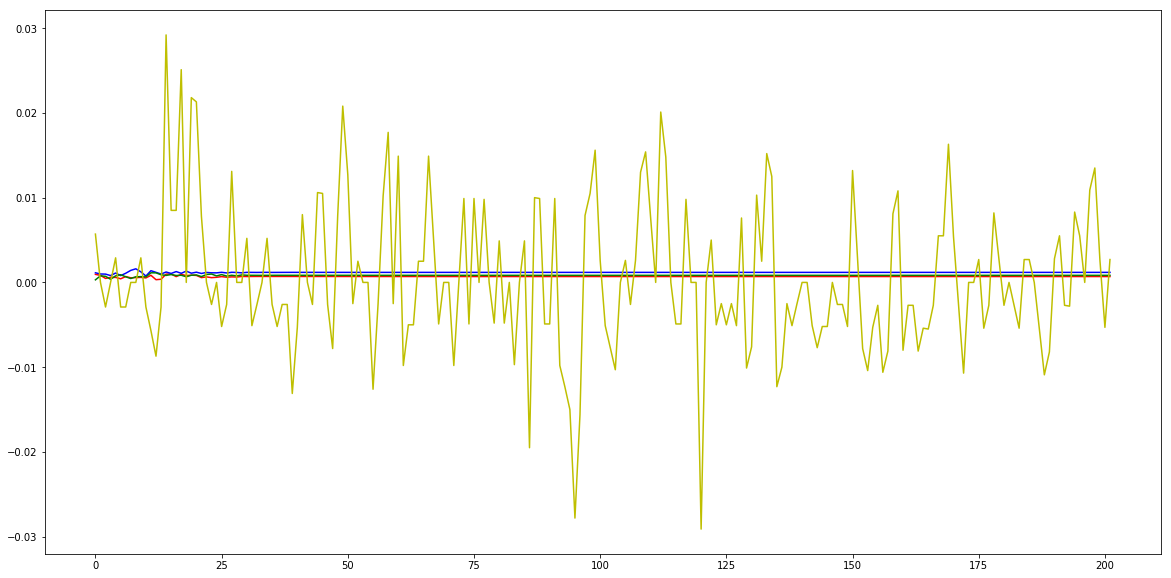

CENTEL


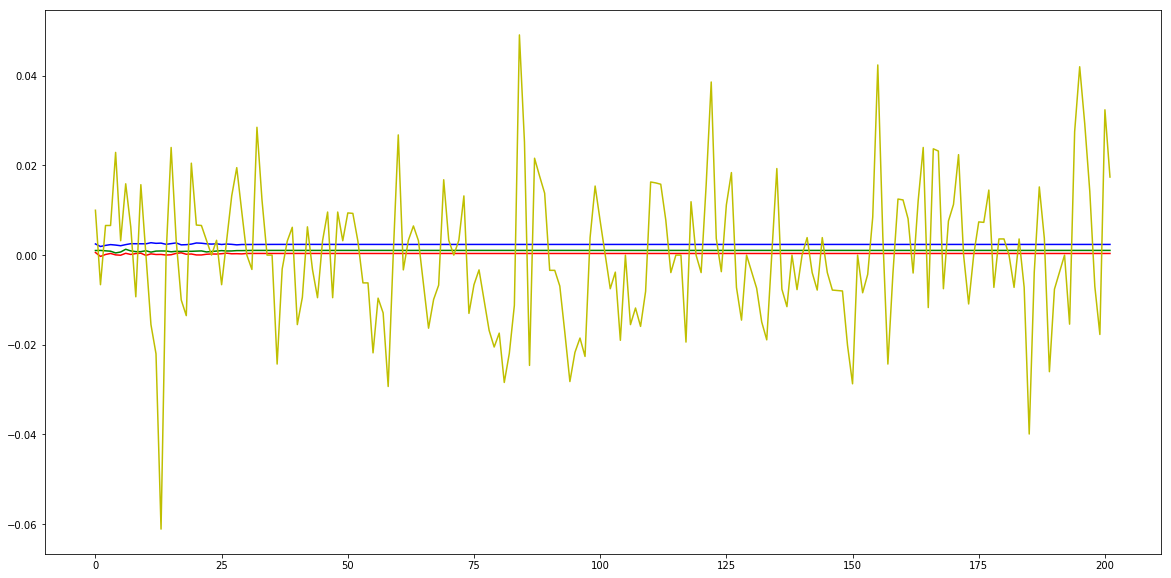

CPALL


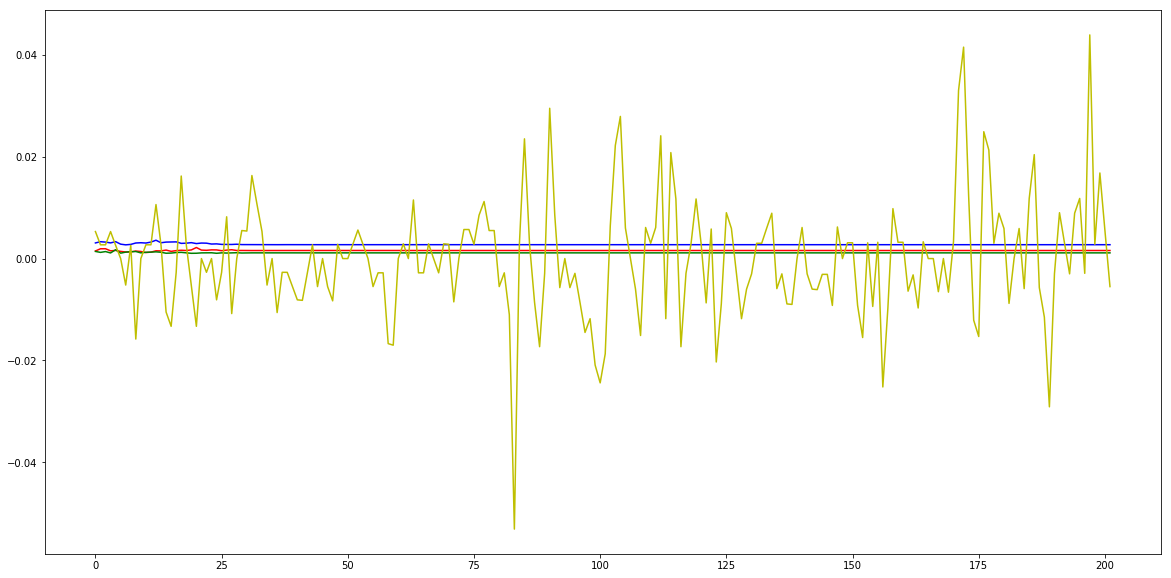

CPF


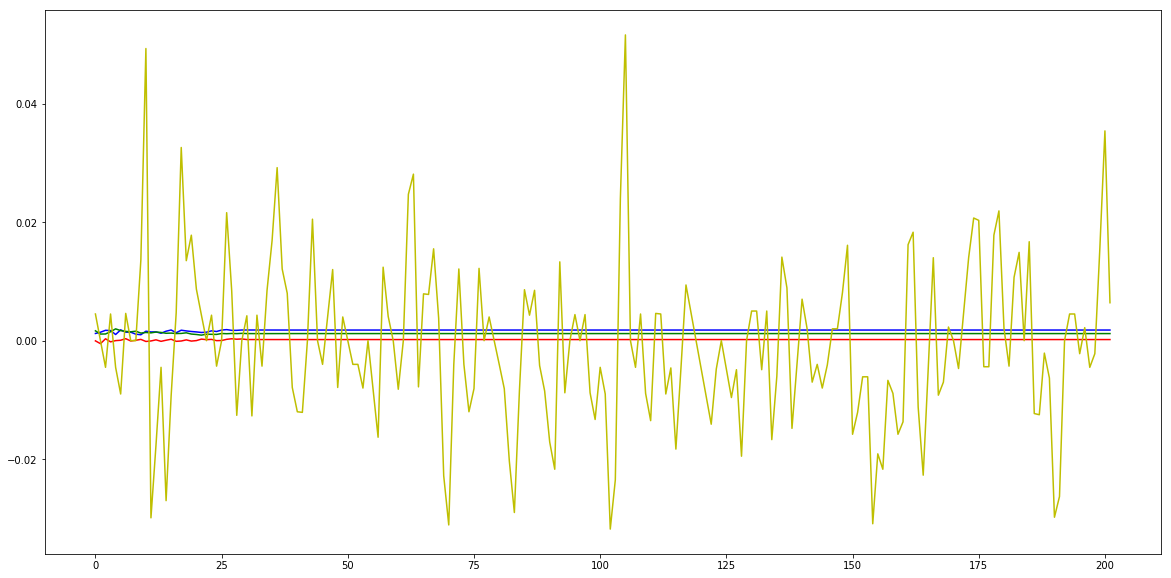

CPN


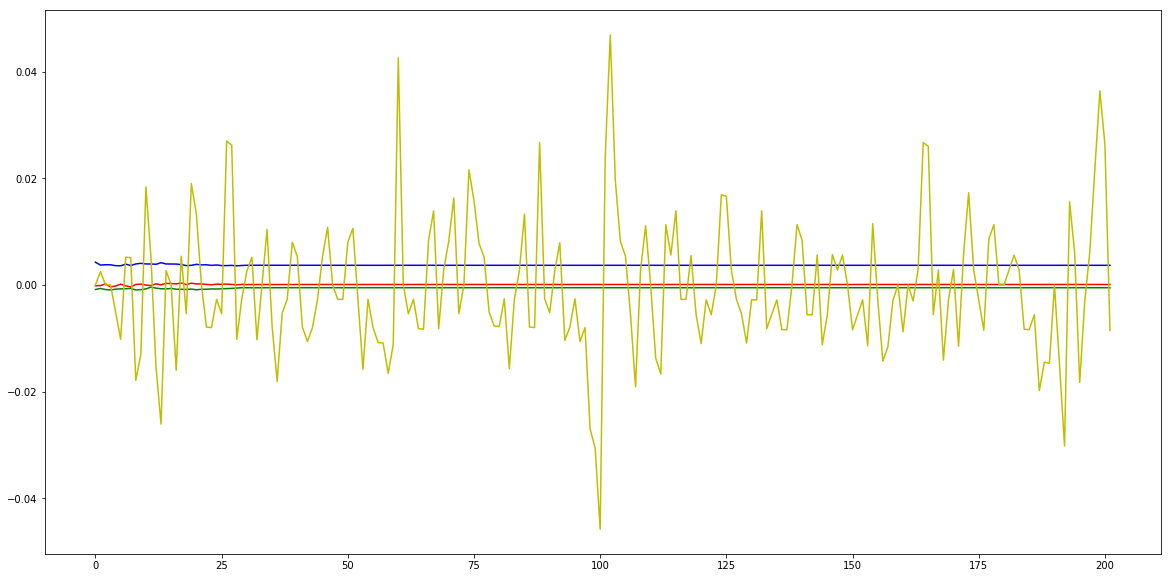

DTAC


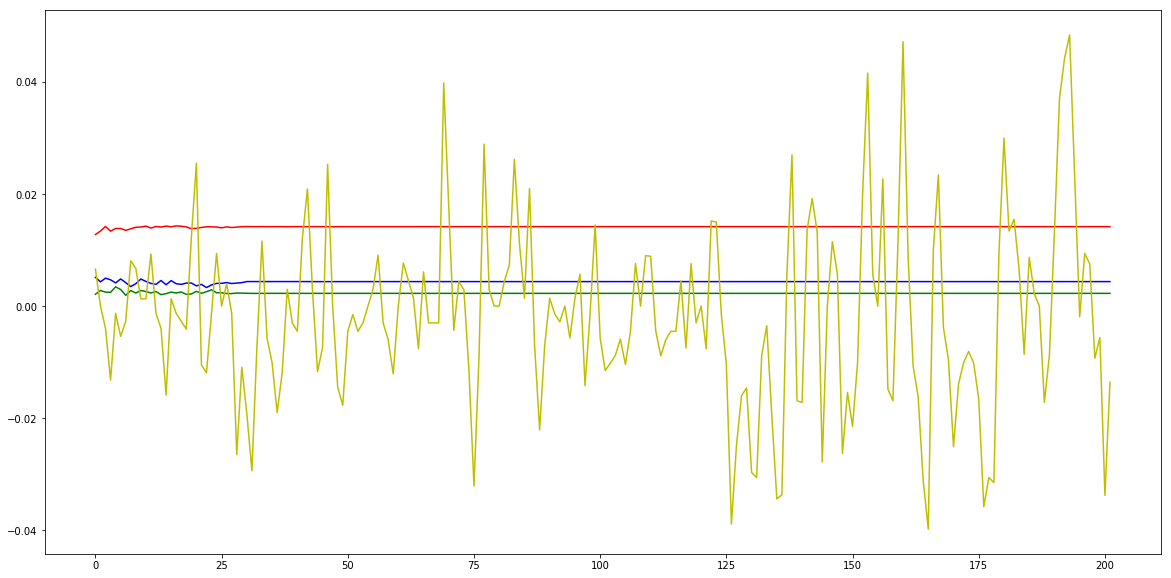

EGCO


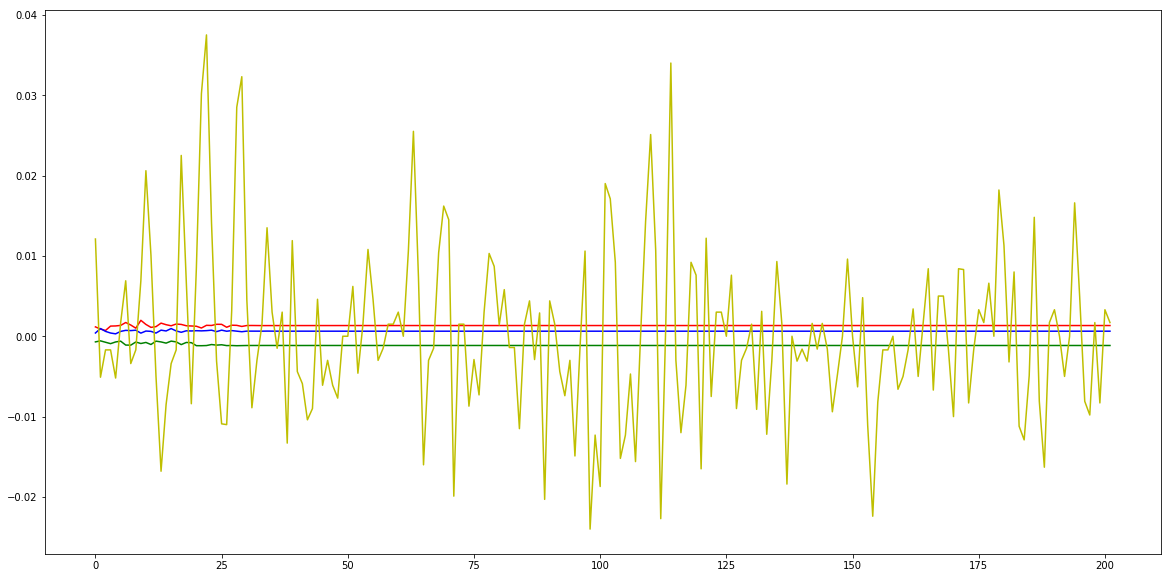

GLOBAL


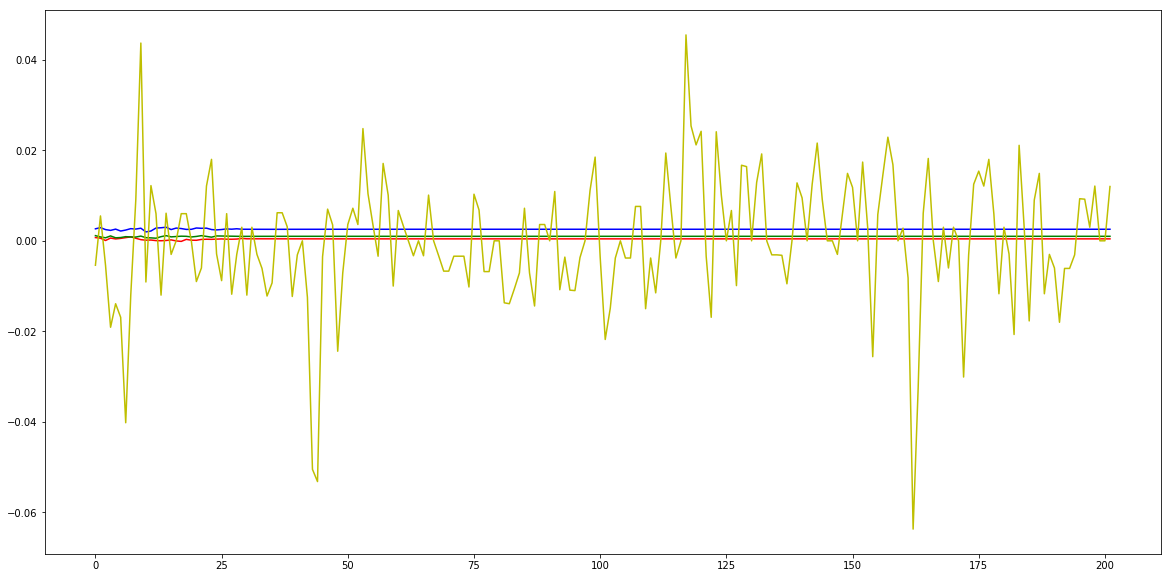

HMPRO


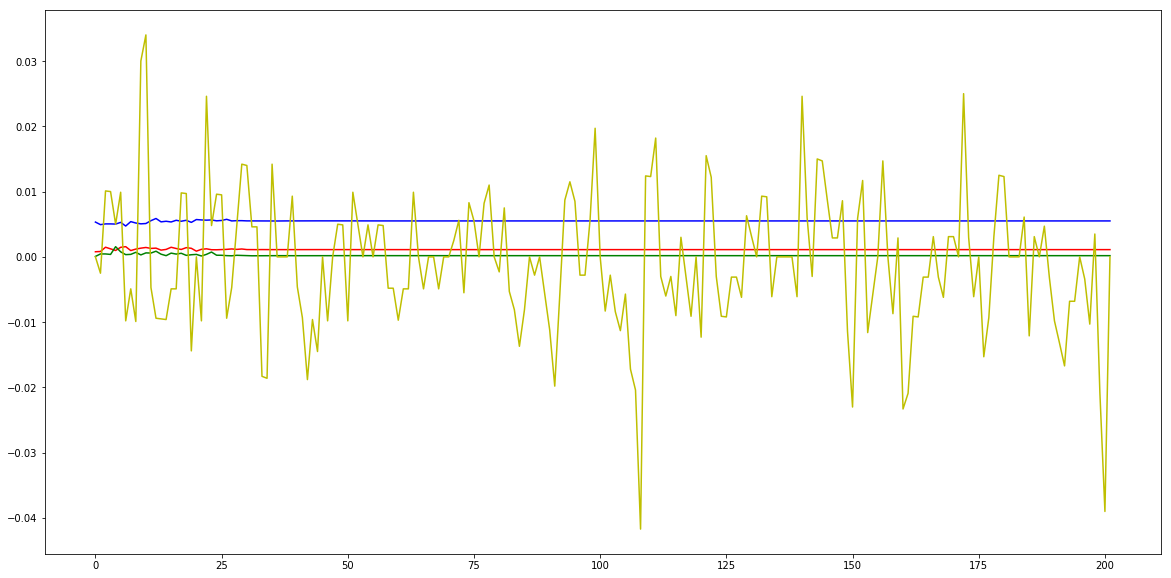

In [ ]:
for i in range(len(SET50)):
    print(SET50[i])
    data1 = get_data_from_nparray(predicts[12], i)
    data2 = get_data_from_nparray(predicts[13], i)
    data3 = get_data_from_nparray(predicts[14], i)
    data4 = get_data_from_nparray(y_test, i)
    plot_graph(data1, data2, data3, data4)

In [14]:
# mse, 100 epochs, 1711 training sets, 0.95 learning rate, 0.000001 decay
# first cnn => 256 7, 1: else 128 3, 1
# fully connected => 256 last fc => 37
#0 1 CNN 1 FLC => 6.5723e-04
#1 1 CNN 2 FLC => 6.7325e-04
#2 1 CNN 3 FLC => 6.9919e-04
#3 1 CNN 4 FLC => 7.2087e-04
#4 1 CNN 5 FLC => 7.1927e-04
#5 2 CNN 1 FLC => 7.1719e-04
#6 2 CNN 2 FLC => 7.3114e-04
#7 2 CNN 3 FLC => 7.4343e-04
#8 2 CNN 4 FLC => 7.4581e-04
#9 2 CNN 5 FLC => 7.5375e-04
#10 3 CNN 1 FLC => 7.5262e-04
#11 3 CNN 2 FLC => 7.5572e-04
#12 3 CNN 3 FLC => 7.5437e-04
#13 3 CNN 4 FLC => 7.5807e-04
#14 3 CNN 5 FLC => 7.5880e-04